# Mann-Kendall Test for Trend

This is a non-parametric test that measures change over time. This test has been applied to measure changes in water chemistry. It is discussed in the <a href=http://pubs.usgs.gov/twri/>USGS Techniques of Water-Resources Investigations: Statistical Methods in Water Resources by D.R. Helsel and R.M. Hirsch</a>.

For these scripts to work on your computer, you need numpy, pandas, urllib2, and scipy.  These are all very useful Python packages.  For windows users, I found that these distributions work very well: http://www.lfd.uci.edu/~gohlke/pythonlibs/

In [1]:
import numpy as np
import pandas as pd
import urllib2
import scipy
from scipy.stats import norm

In [2]:
import wellapplication as wa

The following script is a slightly modified version of a script from the package <a href=http://pydoc.net/Python/ambhas/0.4.0/ambhas.stats/>ambhas</a>, by Sat Kumar Tomer. It calculates various statistics via the Mann Kendall Test.

In [3]:
def mk_test(x, alpha = 0.05):
    """
    this perform the MK (Mann-Kendall) test to check if there is any trend present in 
    data or not
    
    Input:
        x:   a vector of data
        alpha: significance level
    
    Output:
        trend: tells the trend (increasing, decreasing or no trend)
        h: True (if trend is present) or False (if trend is absence)
        p: p value of the sifnificance test
        z: normalized test statistics 
        
    Examples
    --------
      >>> x = np.random.rand(100)
      >>> trend,h,p,z = mk_test(x,0.05) 
      
    Credit: http://pydoc.net/Python/ambhas/0.4.0/ambhas.stats/
    """
    n = len(x)
    
    # calculate S 
    s = 0
    for k in xrange(n-1):
        for j in xrange(k+1,n):
            s += np.sign(x[j] - x[k])
    
    # calculate the unique data
    unique_x = np.unique(x)
    g = len(unique_x)
    
    # calculate the var(s)
    if n == g: # there is no tie
        var_s = (n*(n-1)*(2*n+5))/18
    else: # there are some ties in data
        tp = np.zeros(unique_x.shape)
        for i in xrange(len(unique_x)):
            tp[i] = sum(unique_x[i] == x)
        var_s = (n*(n-1)*(2*n+5) - np.sum(tp*(tp-1)*(2*tp+5)))/18
    
    if s>0:
        z = (s - 1)/np.sqrt(var_s)
    elif s == 0:
        z = 0
    elif s<0:
        z = (s + 1)/np.sqrt(var_s)
    else:
        z = 0
    
    # calculate the p_value
    p = 2*(1-norm.cdf(abs(z))) # two tail test
    h = abs(z) > norm.ppf(1-alpha/2) 
    
    if (z<0) and h:
        trend = 'decreasing'
    elif (z>0) and h:
        trend = 'increasing'
    else:
        trend = 'no trend'
        
    return pd.Series({'trend':trend, 'varS':round(var_s,3), 'p':round(p,3), 'z':round(z,3), 's':round(s,3)})

The following script was written to check the mk_test.  It was written using the Python <a href=http://pandas.pydata.org/>Pandas</a> library.  Pandas handles structured data very well. This function is extremely slow relative to the one above.

In [4]:
def mk_pand(df, const, group1, orderby):
    df.is_copy = False
    df.reset_index(inplace=True, drop=True)
    df.sort(columns=[group1,orderby],axis=0, inplace=True)
    
    def ties(x):
        if x >0:
            x = x+1
            return (x)*(x-1)*(x*2+5)
        else:
            return 0.0

    def zcalc(Sp, Varp):
        if Sp > 0:
            return (Sp - 1)/Varp**0.5
        elif Sp < 0:
            return (Sp + 1)/Varp**0.5
        else:
            return 0    

    g = 0
    k, tau,combo = [], [], []
    for k, v in df.groupby(group1):
        v.is_copy = False
        for i in range(g,len(v.ix[:,const])-1+g):
            v.ix[i,'c'] = np.count_nonzero((v.ix[i:,const].values > v.ix[i,const])) 
            v.ix[i,'d'] = np.count_nonzero((v.ix[i:,const].values < v.ix[i,const]))
            v.ix[i,'t'] = len(v) - v.ix[i,'c'] - v.ix[i,'d'] - i - 1 + g

        g = len(v.ix[:,const])+g
        v.ix[:,'sC'] = v.ix[:,'c'].cumsum()
        v.ix[:,'sD'] = v.ix[:,'d'].cumsum()
        v.ix[:,'S'] = (v.ix[:,'sC'] - v.ix[:,'sD'])
        v.ix[:,'count'] = (v.ix[:,'sC'] + v.ix[:,'sD'])
        v.ix[:,'tau'] = (v.ix[:,'S'])/(v.ix[:,'count'])

        v.ix[:,'sT'] = v.ix[:,'t'].apply(lambda x: ties(x)).cumsum()
        v.ix[:,'n'] = len(v)
        v.ix[:,'VarS'] = (len(v)*(len(v)-1)*(len(v)*2+5)-(v.ix[:,'sT']))/18.0
        v.ix[:,'z'] = v.apply(lambda x: zcalc(x['S'],x['VarS']),1) 
        v.ix[:,'prob'] = norm.pdf(v.ix[:,'z'])
        #v.ix[:,'taub'] = (v.ix[:,'sC'] - v.ix[:,'sD'])/np.sqrt(v.ix[:,'count']*(v.ix[:,'count']-v.ix[:,'sT']))

        v.dropna(inplace=True)
        b = v.tail(1)
        combo.append(b)

    combo = pd.concat(combo)
    Sp = combo.S.sum()
    Varp = combo.VarS.sum()
    total = combo.n.sum()


    Z = zcalc(Sp, Varp)
    print norm.pdf(Z), Sp, Varp

# Water Resources Research Hirsch 1982 Example

This section is devoted to reproducing the Mann Kendall seasonal analysis conducted by Robert Hirsch and others in their paper on <a href=https://profile.usgs.gov/myscience/upload_folder/ci2012Oct1508260828033Techniques%20of%20Trend%20Analysis%20for%20Monthly%20Water%20Quality%20Data.pdf>_Techniques of Trend Analysis for Monthly Water Quality Data_</a>.

First we import the data used in the paper from the relevant USGS station from the NWIS database. <a href=http://nwis.waterdata.usgs.gov/usa/nwis/qwdata/?site_no=11530500&agency_cd=USGS&inventory_output=0&rdb_inventory_output=file&TZoutput=0&pm_cd_compare=Greater%20than&radio_parm_cds=parm_cd_list&radio_multiple_parm_cds=00665&qw_attributes=0&format=rdb&qw_sample_wide=wide&rdb_qw_attributes=0&date_format=YYYY-MM-DD&rdb_compression=value&submitted_form=brief_list>Click here to see the raw data</a>.

In [3]:
# import data via rest query
infile= r'http://nwis.waterdata.usgs.gov/usa/nwis/qwdata/?site_no=11530500&agency_cd=USGS&inventory_output=0&rdb_inventory_output=file&TZoutput=0&pm_cd_compare=Greater%20than&radio_parm_cds=parm_cd_list&radio_multiple_parm_cds=00665&qw_attributes=0&format=rdb&qw_sample_wide=wide&rdb_qw_attributes=0&date_format=YYYY-MM-DD&rdb_compression=value&submitted_form=brief_list'
#response = urllib2.urlopen(infile)

# designate header
cols = ['datetime','agency','site','end_dt','end_tm','dtm','dtm_cd','coll_ent_cd','medium_cd','tu_id','body_part_id','PO4']

# read data into a Pandas dataframe
usgsP = pd.read_table(infile, skiprows=65, skipfooter=5, na_values=('-','','No Data','No data'),
                      parse_dates={'datetime':[2,3]}, engine='python')
usgsP.columns = cols

# set row names as datetime
usgsP.set_index('datetime',inplace=True)

# drop unused columns
usgsP.drop(['agency','site','end_dt','end_tm','dtm','dtm_cd','coll_ent_cd','medium_cd','tu_id','body_part_id'],axis=1,inplace=True)

# add year and month columns
usgsP['month'] = usgsP.index.to_datetime().month.astype(int)
usgsP['year'] = usgsP.index.to_datetime().year.astype(int)

# filter data to relevant dates
usgsP = usgsP[(usgsP['year']>=1972) & (usgsP.index.to_datetime() <= pd.datetime(1979,10,31))]

# sort data by month then year for analysis
usgsP.sort_values(by=['month','year'],axis=0, inplace=True)

# remove strings from data column and convert to numbers
usgsP['PO4'] = usgsP['PO4'].map(lambda x: x.strip('><E '))
#usgsP['PO4'] = usgsP['PO4'].astype(float)

usgsP['PO4'] = pd.to_numeric(usgsP['PO4'])
usgsP.dropna(inplace=True)

If we bring in <a href=http://matplotlib.org/>matplotlib</a>, we can graph these data, reproducing figure 1 in the report.

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt
from pylab import rcParams
rcParams['figure.figsize'] = 15, 10

(0.0, 1.4)

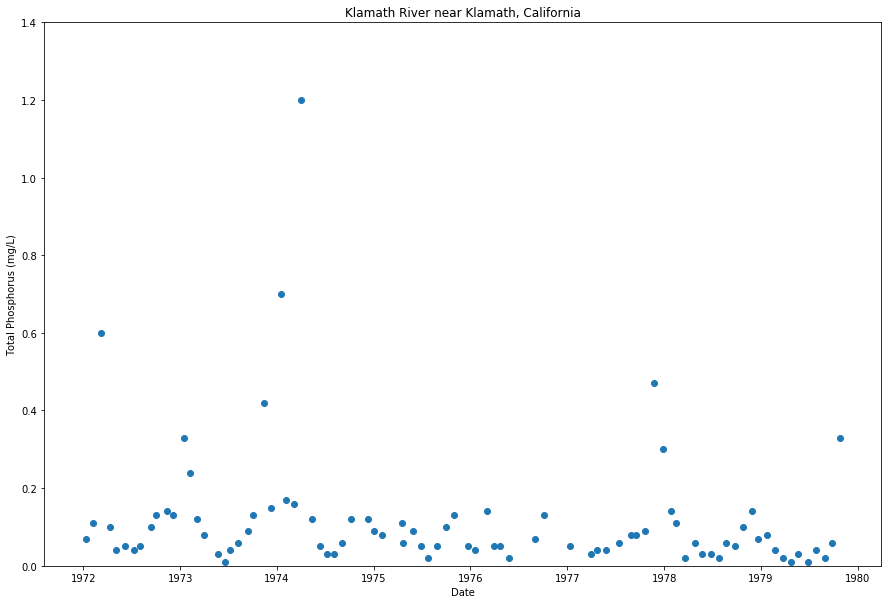

In [5]:
x = usgsP.index.to_datetime()
y = usgsP['PO4'].values

plt.figure()
plt.scatter(x,y)
plt.title('Klamath River near Klamath, California')
plt.xlabel('Date')
plt.ylabel('Total Phosphorus (mg/L)')
plt.ylim(0.0,1.4)

To analayze the data, we will adjust the `mk_test` function to work in Pandas, so we can group the data into regions.

In [8]:
def mk_ts(df, const, group1, orderby = 'year', alpha = 0.05):
    '''
    df = dataframe
    const = variable tested for trend
    group1 = variable to group by
    orderby = variable to order by (typically a date)
    '''
    
    def mk_test(x, alpha):
        """
        this perform the MK (Mann-Kendall) test to check if there is any trend present in 
        data or not

        Input:
            x:   a vector of data
            alpha: significance level

        Output:
            trend: tells the trend (increasing, decreasing or no trend)
            h: True (if trend is present) or False (if trend is absence)
            p: p value of the sifnificance test
            z: normalized test statistics 

        Examples
        --------
          >>> x = np.random.rand(100)
          >>> trend,h,p,z = mk_test(x,0.05) 

        Credit: http://pydoc.net/Python/ambhas/0.4.0/ambhas.stats/
        """
        n = len(x)
        ta = n*(n-1)/2
        # calculate S 
        s = 0
        for k in xrange(n-1): # this does not work with nan values
            for j in xrange(k+1,n):
                s += np.sign(x[j] - x[k])

        # calculate the unique data
        unique_x = np.unique(x)
        g = len(unique_x)

        # calculate the var(s)
        if n == g: # there is no tie
            var_s = (n*(n-1)*(2*n+5))/18
        else: # there are some ties in data
            tp = np.zeros(unique_x.shape)
            for i in xrange(len(unique_x)):
                tp[i] = sum(unique_x[i] == x)
            var_s = (n*(n-1)*(2*n+5) - np.sum(tp*(tp-1)*(2*tp+5)))/18
        
        # calculate z value
        if s > 0.0:
            z = (s - 1)/np.sqrt(var_s)
        elif s == 0.0:
            z = 0
        elif s < 0.0:
            z = (s + 1)/np.sqrt(var_s)
        else:
            print('problem with s')

        # calculate the p_value
        p = 2*(1-norm.cdf(abs(z))) # two tail test
        h = abs(z) > norm.ppf(1-alpha/2) 

        if (z<0) and h:
            trend = 'decreasing'
        elif (z>0) and h:
            trend = 'increasing'
        else:
            trend = 'no trend'

        return pd.Series({'trend':trend, 'varS':round(var_s,3), 'p':round(p,3), 'z':round(z,3), 's':round(s,3), 'n':n, 'ta':ta})

    def zcalc(Sp, Varp):
        if Sp > 0:
            return (Sp - 1)/Varp**0.5
        elif Sp < 0:
            return (Sp + 1)/Varp**0.5
        else:
            return 0   
    
    df.is_copy = False
    
    df[const] = df.ix[:,const].convert_objects(convert_numeric=True)
    # remove null values
    df[const].dropna(inplace=True)
    # remove index
    df.reset_index(inplace=True, drop=True)
    # sort by groups, then time
    df.sort(columns=[group1,orderby],axis=0, inplace=True)
    
    # group by group and apply mk_test
    dg = df.groupby(group1).apply(lambda x: mk_test(x.loc[:,const].dropna().values, alpha))
    Var_S = dg.loc[:,'varS'].sum()
    S = dg.loc[:,'s'].sum()
    N = dg.loc[:,'n'].sum()
    Z = zcalc(S,Var_S)
    P = 2*(1-norm.cdf(abs(Z)))
    group_n = len(dg)
    h = abs(Z) > norm.ppf(1-alpha/2) 
    tau = S/dg.loc[:,'ta'].sum()

    if (Z<0) and h:
        trend = 'decreasing'
    elif (Z>0) and h:
        trend = 'increasing'
    else:
        trend = 'no trend'
    
    
    return pd.Series({'S':S, 'Z':round(Z,2), 'p':P, 'trend':trend, 'group_n':group_n, 'sample_n':N, 'Var_S':Var_S, 'tau':round(tau,2)})

In [12]:
usgsP['PO4'] = usgsP['PO4'].apply(lambda x: round(x, 3),1)
usgsP.to_csv('C:/Users/PAULINKENBRANDT/Documents/GitHub/WellApplication/test/usgsP.csv')

In [16]:
def test_mk_ts():
    usgsP = pd.read_csv('./usgsP.csv')
    var = wa.MannKendall.mk_ts(usgsP, 'PO4', 'month', 'year',0.05)
    assert var[0] == -87.0
test_mk_ts()

AssertionError: 

We can run the modified script on the USGS data to see if we can reproduce the results in the manuscript.

In [14]:
var = wa.MannKendall.mk_ts(usgsP, 'PO4', 'month', 'year',0.05)
assert var[0] == -87

-87.0

In [10]:
mk_pand(usgsP,'PO4','month','year')

0.000373972800628 -89.0 555.333333333


c:\python27\arcgis10.3\lib\site-packages\ipykernel\__main__.py:4: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


The results listed in the publication are slightly different, which may be due to the different sample size, but the conclusions are the same: <br>
`S' = -62` <br>
`Var[S'] = 514` <br>
`Z' = -2.69` <br>
`n = 80` <br>
Two Sided p <br>
`p = Prob[|S'| >= 62] = 0.0072`.

# USGS Scientific Investigations Report 2012–5049

This is an example from a <a href=http://pubs.usgs.gov/sir/2012/5049/>USGS report</a> examining regional trends of nitrate, chloride, and total dissolved solids over time for various National Water-Quality Assessment (NAWQA) stations.

## Mann-Kendall Regional

The following script links directly to <a href=http://pubs.usgs.gov/sir/2012/5049/support/SIR2012_5049_Appendix_2_04022012.xlsx>Appendix 2 (Excel spreadsheets)</a> of the <a href=http://pubs.usgs.gov/sir/2012/5049/> report</a>.

In [11]:
infile2 = r'http://pubs.usgs.gov/sir/2012/5049/support/SIR2012_5049_Appendix_2_04022012.xlsx'
response2 = urllib2.urlopen(infile2)
cols = ['site','unit','network','date','time','Nrem','N','Clrem','Cl','TDSrem', 'TDS']

# import data into Pandas Dataframe
usgsT = pd.read_excel(response2, skiprows=1, skip_footer=5, na_values=('-','','No Data','No data','.'),converters={0:np.str})#, parse_cols=cols)
usgsT.columns = cols

# Parse Dates
usgsT['strTime'] = usgsT['time'].apply(lambda x: '0000' if np.isnan(x)==True else str(str(int(x)).zfill(4)))
usgsT['strdate'] = usgsT['date'].apply(lambda x: str(x)[:10])
usgsT['datetime'] = pd.to_datetime(usgsT['strdate'] + usgsT['strTime'], format='%Y-%m-%d%H%M', errors='coerce')
usgsT.drop(['strTime','strdate'],axis=1,inplace=True)
usgsT.reset_index(inplace=True, drop=True)
usgsT['year'] = usgsT.index.to_datetime().year.astype(int)
usgsT.sort_values(by=['network', 'site', 'year'],axis=0, inplace=True)

In [12]:
usgsT

,site,unit,network,date,time,Nrem,N,Clrem,Cl,TDSrem,TDS,datetime,year
0,310552084435601,ACFB,acfbluscr3,1993-08-25,1510,NaN,4.700,NaN,3.800,NaN,153.00,1993-08-25 15:10:00,1970
1,310552084435601,ACFB,acfbluscr3,1994-04-05,1400,NaN,5.200,NaN,4.200,NaN,135.00,1994-04-05 14:00:00,1970
2,310552084435601,ACFB,acfbluscr3,1999-09-15,1000,NaN,6.981,NaN,NaN,NaN,NaN,1999-09-15 10:00:00,1970
3,310552084435601,ACFB,acfbluscr3,2002-04-11,1600,NaN,7.970,NaN,5.250,NaN,151.84,2002-04-11 16:00:00,1970
4,310552084435601,ACFB,acfbluscr3,2005-07-21,1100,NaN,11.671,NaN,5.873,NaN,225.81,2005-07-21 11:00:00,1970
5,310552084435601,ACFB,acfbluscr3,2007-08-15,1045,NaN,12.731,NaN,6.318,NaN,232.14,2007-08-15 10:45:00,1970
6,310552084435601,ACFB,acfbluscr3,2009-08-18,1400,NaN,12.898,NaN,7.028,NaN,245.30,2009-08-18 14:00:00,1970
7,310913084195301,ACFB,acfbluscr3,1993-08-24,1645,NaN,1.500,NaN,3.600,NaN,133.00,1993-08-24 16:45:00,1970
8,310913084195301,ACFB,acfbluscr3,1994-04-05,1030,NaN,1.500,NaN,3.700,NaN,136.00,1994-04-05 10:30:00,1970
9,310913084195301,ACFB,acfbluscr3,2001-06-27,1000,NaN,2.539,NaN,NaN,NaN,NaN,2001-06-27 10:00:00,1970


We will now try to reproduce the results listed in tables 6-9 of the report (starting on page 41) for the Mann Kendall Test.  

### Table 6

In [13]:
combo, names = [],[]
# we gill group stations by network to analyze each network.
for k, v in usgsT.groupby('network'):
    combo.append(mk_ts(v, 'Cl','site','datetime', 0.10))
    names.append(k)
pd.DataFrame(combo, index=names)

c:\python27\arcgis10.3\lib\site-packages\ipykernel\__main__.py:85: FutureWarning: convert_objects is deprecated.  Use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.
c:\python27\arcgis10.3\lib\site-packages\ipykernel\__main__.py:91: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


,S,Var_S,Z,group_n,p,sample_n,tau,trend
acfbluscr3,29,140,2.37,5,0.017960,30,0.39,increasing
acfbsus1,26,72,2.95,5,0.003216,24,0.57,increasing
albelusag1,12,48,1.59,5,0.112351,21,0.35,no trend
cazbsus1a,10,80,1.01,5,0.314305,25,0.20,no trend
ccptlusag2b,-58,325,-3.16,5,0.001568,40,-0.41,decreasing
ccptlusor1b,-35,92,-3.54,5,0.000393,26,-0.64,decreasing
ccptsus1b,4,80,0.34,5,0.737316,25,0.08,no trend
dlmvluscr1,-2,72,-0.12,5,0.906186,24,-0.04,no trend
dlmvsus1,16,72,1.77,5,0.077100,24,0.35,increasing
eiwaluscr1,6,72,0.59,5,0.555690,24,0.13,no trend


### Table 7

In [12]:
combo, names = [],[]
for k, v in usgsT.groupby('network'):
    combo.append(mk_ts(v, 'TDS','site','datetime', 0.10))
    names.append(k)
pd.DataFrame(combo, index=names)

,S,Var_S,Z,group_n,p,sample_n,tau,trend
acfbluscr3,31,140.000,2.54,5,0.011230,30,0.41,increasing
acfbsus1,24,72.000,2.71,5,0.006717,24,0.52,increasing
albelusag1,4,48.000,0.43,5,0.665006,21,0.12,no trend
cazbsus1a,4,80.000,0.34,5,0.737316,25,0.08,no trend
ccptlusag2b,-22,325.000,-1.16,5,0.244071,40,-0.16,no trend
ccptlusor1b,-31,92.000,-3.13,5,0.001762,26,-0.56,decreasing
ccptsus1b,18,80.000,1.90,5,0.057347,25,0.36,increasing
dlmvluscr1,4,40.000,0.47,5,0.635256,20,0.13,no trend
dlmvsus1,7,35.000,1.01,5,0.310494,19,0.26,no trend
eiwaluscr1,-10,72.000,-1.06,5,0.288844,24,-0.22,no trend


### Table 8

In [13]:
combo, names = [],[]
for k, v in usgsT.groupby('network'):
    combo.append(mk_ts(v, 'N','site','datetime', 0.10))
    names.append(k)
pd.DataFrame(combo, index=names)

,S,Var_S,Z,group_n,p,sample_n,tau,trend
acfbluscr3,45,238.666,2.85,5,0.004398,36,0.40,increasing
acfbsus1,26,72.000,2.95,5,0.003216,24,0.57,increasing
albelusag1,-2,24.000,-0.20,5,0.838256,21,-0.06,no trend
cazbsus1a,10,80.000,1.01,5,0.314305,25,0.20,no trend
ccptlusag2b,-33,559.000,-1.35,5,0.175910,48,-0.16,no trend
ccptlusor1b,-35,140.000,-2.87,5,0.004059,30,-0.47,decreasing
ccptsus1b,-7,140.000,-0.51,5,0.612090,30,-0.09,no trend
dlmvluscr1,8,56.000,0.94,5,0.349575,23,0.19,no trend
dlmvsus1,4,24.000,0.61,5,0.540291,21,0.12,no trend
eiwaluscr1,-7,61.000,-0.77,5,0.442356,24,-0.15,no trend


## Decadal Data: Wilcoxan-Pratt Signed-Rank Analysis

The following script links directly to <a href=http://pubs.usgs.gov/sir/2012/5049/support/SIR2012_5049_Appendix_1_04022012.xlsx>Appendix 1 (Excel spreadsheets)</a> of the <a href=http://pubs.usgs.gov/sir/2012/5049/> report</a>. Unfortunately, this analysis does not account for nondetects, as methods for treating censored data are still being developed.

In [48]:
infile2 = r'http://pubs.usgs.gov/sir/2012/5049/support/SIR2012_5049_Appendix_1_04022012.xlsx'
response2 = urllib2.urlopen(infile2)
cols = ['site','unit','network','use','aquifer','rock','depth','date','time','Nrem','N','Clrem',
        'Cl','TDSrem', 'TDS', 'date1','time1','Nrem1','N1','Clrem1','Cl1','TDSrem1','TDS1']

usgs = pd.read_excel(response2, skiprows=1, skip_footer=5, na_values=('-','','No Data','No data'))#, parse_cols=cols)
usgs.columns = cols

# replace nondetects with zero - I know this isn't best, but python is limited here
usgs['N'] = usgs[['N','Nrem']].apply(lambda x: 0 if x[1]=='<' else x[0],1)
usgs['TDS'] = usgs[['TDS','TDSrem']].apply(lambda x: 0 if x[1]=='<' else x[0],1)
usgs['Cl'] = usgs[['Cl','Clrem']].apply(lambda x: 0 if x[1]=='<' else x[0],1)
usgs['N1'] = usgs[['N1','Nrem1']].apply(lambda x: 0 if x[1]=='<' else x[0],1)
usgs['TDS1'] = usgs[['TDS1','TDSrem1']].apply(lambda x: 0 if x[1]=='<' else x[0],1)
usgs['Cl1'] = usgs[['Cl1','Clrem1']].apply(lambda x: 0 if x[1]=='<' else x[0],1)
usgs

,site,unit,network,use,aquifer,rock,depth,date,time,Nrem,...,TDSrem,TDS,date1,time1,Nrem1,N1,Clrem1,Cl1,TDSrem1,TDS1
0,305641084542001,ACFB,acfbluscr3,UNUSED,Floridan aquifer system,Carbonate-rock aquifers,54.3,1993-08-26,1215,NaN,...,NaN,219,2002-04-22,1200,NaN,2.074,NaN,3.51,NaN,144.43
1,310552084435601,ACFB,acfbluscr3,UNUSED,Floridan aquifer system,Carbonate-rock aquifers,68.8,1993-08-25,1510,NaN,...,NaN,153,2002-04-11,1600,NaN,7.970,NaN,5.25,NaN,151.84
2,310604084351901,ACFB,acfbluscr3,UNUSED,Floridan aquifer system,Carbonate-rock aquifers,36.4,1993-08-31,950,NaN,...,NaN,256,2003-09-24,1500,NaN,12.705,NaN,9.66,NaN,218.43
3,310752085271301,ACFB,acfbluscr3,UNUSED,Floridan aquifer system,Carbonate-rock aquifers,48.2,1993-08-25,1640,NaN,...,NaN,125,2002-03-20,1200,NaN,1.585,NaN,3.37,NaN,142.12
4,310913084195301,ACFB,acfbluscr3,UNUSED,Surficial aquifer system,Non-glacial sand and gravel aquifers,47.5,1993-08-24,1645,NaN,...,NaN,133,2002-04-10,1200,NaN,1.704,NaN,3.21,NaN,146.14
5,311015084511901,ACFB,acfbluscr3,UNUSED,Floridan aquifer system,Carbonate-rock aquifers,65.0,1993-08-30,1110,NaN,...,NaN,121,2002-04-22,1700,NaN,0.175,NaN,2.08,NaN,68.38
6,311141084513401,ACFB,acfbluscr3,UNUSED,Floridan aquifer system,Carbonate-rock aquifers,69.3,1993-08-30,1500,NaN,...,NaN,150,2002-03-05,1400,NaN,2.175,NaN,4.35,NaN,154.00
7,311505085140101,ACFB,acfbluscr3,UNUSED,Floridan aquifer system,Carbonate-rock aquifers,49.1,1993-08-25,1215,NaN,...,NaN,207,2002-03-07,1200,NaN,9.847,NaN,8.33,NaN,190.00
8,312119084215601,ACFB,acfbluscr3,UNUSED,Surficial aquifer system,Non-glacial sand and gravel aquifers,48.8,1993-08-31,1500,NaN,...,NaN,139,2002-04-08,1700,NaN,4.366,NaN,3.63,NaN,125.19
9,312346084520401,ACFB,acfbluscr3,UNUSED,Floridan aquifer system,Carbonate-rock aquifers,14.4,1993-08-19,1800,<,...,NaN,223,2002-03-06,1500,NaN,2.023,NaN,8.06,NaN,166.00


In [36]:
-

### Table 4

In [49]:
NitrateTable = USGSchemTab(usgs,'N','network',0.1)
NitrateTable

,T,chng,n,ntwrk,p,signif
0,42.0,0.29,19,acfbluscr3,0.032938,(+)
1,56.0,0.31,21,acfbsus1,0.038632,(+)
2,34.0,0.00,12,albelusag1,0.688447,None
3,129.0,0.14,24,cazbsus1a,0.548506,None
4,65.0,-0.77,16,ccptlusag2b,0.876722,None
5,82.0,0.05,19,ccptlusor1b,0.600871,None
6,189.0,0.02,30,ccptsus1b,0.370885,None
7,59.5,-0.08,16,dlmvluscr1,0.660228,None
8,25.0,0.14,23,dlmvsus1,0.000587,(+)
9,192.5,0.00,30,eiwaluscr1,0.410647,None


### Table 2

In [51]:
ClTable = USGSchemTab(usgs,'Cl','network')
ClTable

,T,chng,n,ntwrk,p,signif
0,90.0,0.01,19,acfbluscr3,0.840534,None
1,45.5,0.35,21,acfbsus1,0.014965,(+)
2,29.0,1.21,12,albelusag1,0.432768,None
3,114.0,1.00,24,cazbsus1a,0.303681,None
4,46.0,-1.97,16,ccptlusag2b,0.255291,None
5,88.0,0.64,19,ccptlusor1b,0.778177,None
6,155.0,0.60,30,ccptsus1b,0.110926,None
7,23.0,8.15,16,dlmvluscr1,0.019971,(+)
8,57.0,1.81,23,dlmvsus1,0.013755,(+)
9,168.0,0.55,30,eiwaluscr1,0.184622,None


### Table 3

In [50]:
TDSTable = USGSchemTab(usgs,'TDS','network')
TDSTable

,T,chng,n,ntwrk,p,signif
0,51.0,-6.00,19,acfbluscr3,0.076588,(-)
1,82.0,4.06,21,acfbsus1,0.244270,None
2,21.0,4.05,12,albelusag1,0.157939,None
3,70.0,27.84,24,cazbsus1a,0.022271,(+)
4,59.0,-5.98,16,ccptlusag2b,0.641660,None
5,71.0,-9.13,19,ccptlusor1b,0.334138,None
6,55.0,13.31,30,ccptsus1b,0.000261,(+)
7,0.0,NaN,16,dlmvluscr1,0.000438,(+)
8,0.0,NaN,23,dlmvsus1,0.000027,(+)
9,214.0,-15.65,30,eiwaluscr1,0.703564,None
